# Demo series: Controllers & Agents

---

## Active Inference for controlling a driven damped harmonic oscillator

Wouter Kouw, 06-08-2021

### System

This project considers a [harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator#Driven_harmonic_oscillators). Consider $y(t)$ as observed displacement, $x(t)$ as the unobserved state, $u(t)$ as the driving force and $e(t)$ as measurement noise. The continuous-time dynamics of the system are:

$$\begin{align}
m \frac{d^2 x(t)}{dt^2} =&\ - c \frac{d x(t)}{dt} - k x(t) + u(t) \\
y(t) =&\ x(t) + e(t)
\end{align}$$
where 
$$
m     = \text{mass} \, , \quad
c     = \text{damping} \, , \quad
k     = \text{spring stiffness} \, ,
$$
constitute the physical parameters. 

The measurement noise is a Wiener process, with $v(t) \sim \mathcal{N}(0, \xi^{-1}dt)$ and $\xi$ as precision parameter. Note that nearly all Gaussian distributions in this demo use [precision](https://en.wikipedia.org/wiki/Precision_%28statistics%29) instead of variance. By convention, $\mathcal{N}$ uses a mean-covariance notation, so we invert precision parameters / matrices.

#### First-order system in generalised coordinates

We will first adopt a more concise notation and then divide by the leading coefficient:

$$ x'' = \frac{-c}{m} x' + \frac{-k}{m} x + \frac{1}{m} u \, .$$

In this demo, we will make the following variable substitutions:

$$ \theta_1 = \frac{-k}{m} \, , \quad \theta_2 = \frac{-c}{m} \, , \quad \eta = \frac{1}{m}, .$$

With that, we cast the above system into a multi-variate first-order form:

$$ \underbrace{\begin{bmatrix} x' \\ x'' \end{bmatrix}}_{z'} = \begin{bmatrix} 0 & 1 \\ \theta_1 & \theta_2 \end{bmatrix}  \begin{bmatrix} x \\ x' \end{bmatrix} + \begin{bmatrix} 0 \\ \eta \end{bmatrix} u \, ,$$

and discretize with $z' = (z_{k+1} - z_k) / \Delta t$ giving:

$$\begin{align} 
\left( \begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} - \begin{bmatrix} x_{k} \\ x'_{k} \end{bmatrix} \right) / \Delta t =&\ \begin{bmatrix} 0 & 1 \\ \theta_1 & \theta_2 \end{bmatrix} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \begin{bmatrix} 0 \\ \eta \end{bmatrix} u_k \\
\begin{bmatrix} x_{k+1} \\ x'_{k+1} \end{bmatrix} =&\ \underbrace{\begin{bmatrix} 1 & \Delta t \\ \theta_1 \Delta t & \theta_2 \Delta t + 1 \end{bmatrix}}_{A(\theta)} \begin{bmatrix} x_k \\ x'_k \end{bmatrix} + \underbrace{\begin{bmatrix} 0 \\ \Delta t \eta \end{bmatrix}}_{B(\eta)} u_k \, .
\end{align}$$

This produces a compact state-space model formulation:

$$\begin{align} 
z_{k+1} =&\ A(\theta) z_k + B(\eta) u_k \\
y_k =&\ c^{\top}x_k + e_k \, ,
\end{align}$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}^{\top}$ is a masking vector.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate();

  Activating environment at `C:\Users\kouww\Research\actinf-oscillator\Project.toml`


In [2]:
using Revise
using Plots
using Colors
pyplot();

In [3]:
# Sampling step size
Δt = 0.1

# Physical parameters
m = 10.0
c = 2.0
k = 4.0

# Measurement noise precision
ξ_true = 1e4

# Pack parameters
phys_params = (m, c, k, ξ_true);

In [4]:
# Interesting variable substitutions
ζ = c/(2*sqrt(m*k))
ω0 = sqrt(k/m)
ω1 = ω0*sqrt(1 - ζ^2)

# Report damping ratio
println("Damping ratio ζ = "*string(ζ))

# Report undamped angular frequency
println("Undamped angular frequency ω_0 = "*string(ω0))

# Report underdamped angular frequency
println("Underdamped angular frequency ω_1 = "*string(ω1))

Damping ratio ζ = 0.15811388300841897
Undamped angular frequency ω_0 = 0.6324555320336759
Underdamped angular frequency ω_1 = 0.6244997998398398


In [5]:
function sim_sys(input, z_kmin1, params)
   "Simulate dynamic system"
    
    # Unpack parameters
    θ, η, ξ = params
    
    # State transition
    z_k = (S + s*θ')*z_kmin1 + s*η*input
    
    # Generate observation
    y_k = [1, 0]'*z_k + sqrt(inv(ξ))*randn(1,)[1]
    
    return y_k, z_k    
end;

In [6]:
# Utility matrices
S = [1. Δt; 0. 1.]
s = [0., Δt]

# State transition coefficients
θ1 = -k/m
θ2 = -c/m
θ_true = [θ1, θ2]

# Control coefficient
η_true = 1/m

# Pack substituted variables
subs_params = (θ_true, η_true, ξ_true)

([-0.4, -0.2], 0.1, 10000.0)

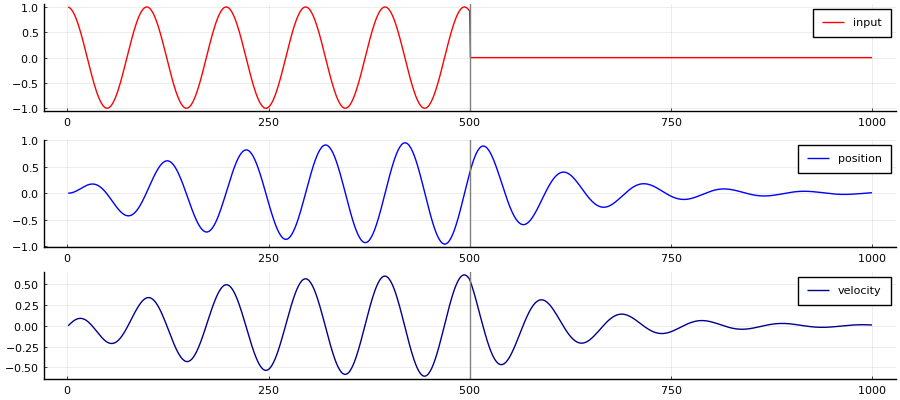

In [7]:
# Time 
T = 1000
stop = T-500

# Input signal
input = [cos.(Δt .*(1:stop)* 2/π); zeros(length(stop+1:T),)]

# Preallocate arrays
states = zeros(T,2)
output = zeros(T,)

for k = 2:T
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], subs_params)
end

p101 = plot(1:T, input, linewidth=1, color="red", label="input", size=(900,300))
vline!([stop], color="gray", label="")
p102 = plot(1:T, states[:,1], linewidth=1, color="blue", label="position", size=(900,300))
vline!([stop], color="gray", label="")
p103 = plot(1:T, states[:,2], linewidth=1, color="darkblue", label="velocity", size=(900,300))
vline!([stop], color="gray", label="")
p100 = plot(p101, p102, p103, layout=(3,1), size=(900,400))

In [8]:
savefig(p100, "figures/example-input-output_seq1.png")

## Model: Adaptive filter in generalised coordinates

In practice, a system is usually affected by external circumstances. We include unknown effects by adding a zero-mean Gaussian noise vector $v_k$:

$$v_k \sim \mathcal{N}\big(0, W(\tau)^{-1} \big) \, , \quad \text{with} \quad W(\tau)^{-1} = \tau \begin{bmatrix} \frac{\Delta t^3}{3} & \frac{\Delta t^2}{2} \\ \frac{\Delta t^2}{2} & \Delta t \end{bmatrix}^{-1} \, ,
$$

where $W$ represents the precision matrix, consisting of a single precision parameter $\tau$ scaling a structured noise precision matrix.

### Likelihood

Integrating out $v_k$ and $e_k$ lets us formulate the dynamics as a Bayesian state-space model:

$$\begin{align}
z_k \sim&\ \mathcal{N}(A(\theta) z_{k-1} + B(\eta) u_k , W(\tau)^{-1}) \\
y_k \sim&\ \mathcal{N}(c^{\top} z_k, \xi^{-1}) \, .
\end{align}$$

### Priors

We choose Gaussian priors for the unknown coefficients and Gamma priors for the unknown noise precisions:

$$\begin{align}
p(\theta) = \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \, , \quad 
p(\eta) = \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \, , \quad  
p(\tau)= \Gamma(a^{0}_\tau, b^{0}_\tau) \, , \quad
p(\xi)= \Gamma(a^{0}_\xi, b^{0}_\xi) \, .
\end{align}$$

We also need a prior distribution for the initial state: $ p(z_0) = \mathcal{N}(0, V_{z_0})$.


### Posteriors

We can apply the Bayesian filtering equations to obtain recursive posterior estimates:

$$\begin{align}\label{eq:filtering}
    \underbrace{p(z_k | x_{1:t})}_{\text{state posterior}} &= \frac{\overbrace{p(x_t | z_t)}^{\text{likelihood}}}{\underbrace{p(x_t | x_{1:t-1})}_{\text{evidence}} }  \overbrace{\iint \underbrace{p(z_t| z_{t-1},u_{t})}_{\text{state transition}} \underbrace{q(u_t)}_{\substack{\text{control} \\ \text{signal}}} \underbrace{p(z_{t-1} | x_{1:t-1})}_{\text{state prior}} \ \mathrm{d} z_{t-1} \mathrm{d} u_t}^{\text{prior predictive $p(z_t | x_{1:t-1})$}} \, ,
\end{align}$$


## Variational Bayesian inference

### Recognition model

The recognition model will follow the generative model:

$$\begin{align}
q(\theta) = \mathcal{N}(m_{\theta}, V_{\theta}) \ , \quad 
q(\eta) = \mathcal{N}(m_{\eta}, v_{\eta}) \ , \quad  
q(\tau)= \Gamma(a_\tau, b_\tau) \, , \quad
q(\xi)= \Gamma(a_\xi, b_\xi) \, .
\end{align}$$

For the states, we have

### Free Energy function



#### Computing expectations

We need to isolate the unknown variables as separate scalar or vector variables, which can be done by splitting the equation as follows:

$$ A(\theta) = \Big(\underbrace{\begin{bmatrix} 1 & \Delta t \\ 0 & 1 \end{bmatrix}}_{S} + \underbrace{\begin{bmatrix} 0 \\ \Delta t \end{bmatrix}}_{s} \begin{bmatrix} \theta_1 & \theta_2 \end{bmatrix} \Big) \, , \quad B(\eta) = \underbrace{\begin{bmatrix} 0 \\ \Delta t \end{bmatrix}}_{s} \eta \, ,$$



In [9]:
using LinearAlgebra
using LaTeXStrings
using ProgressMeter
using Optim
using ForneyLab

In [10]:
using GFX

In [11]:
include("util.jl");

In [12]:
graph1 = FactorGraph()

# Coefficients
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(2,)), placeholder(:w_θ, dims=(2,2)))
@RV η ~ GaussianMeanPrecision(placeholder(:m_η), placeholder(:w_η))

# Noise precisions
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV ξ ~ Gamma(placeholder(:a_ξ), placeholder(:b_ξ))

# State prior
@RV x ~ GaussianMeanPrecision(placeholder(:m_x, dims=(2,)), placeholder(:w_x, dims=(2, 2)), id=:x_k)

# Composite state transition
@RV z ~ GeneralisedFilterX(θ, x, η, placeholder(:u), τ, Δt=Δt, id=:z_k)

# Likelihood
@RV y ~ GaussianMeanPrecision(dot([1., 0.], z), ξ, id=:y_k)
placeholder(y, :y);

# Specify recognition model
q = PosteriorFactorization(z, x, θ, η, τ, ξ, ids=[:z, :x, :θ, :η, :τ, :ξ])

# Specify and compile message passing algorithm
algo = messagePassingAlgorithm([z, x, θ, η, τ, ξ], q)
eval(Meta.parse(algorithmSourceCode(algo)));
# println(algorithmSourceCode(algo))

### Experiment 1: Online system identification from known inputs

In [37]:
# Time horizon
T = 2000
stop = T-500

# Design input signal
input = [cos.(Δt .*(1:stop)./π); zeros(length(stop+1:T),)];

In [38]:
# Preallocation
states = zeros(T,2)
output = zeros(T,)

# Initial state
states[1,:] = [0.0, 0.0]

# Initialize constraints
constraints = Dict()

messages_z = Array{Message}(undef, 4)

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=states[1,:], w=I(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=states[1,:], w=I(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_true, w=1e2 .*I(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=η_true, w=1e2)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1e-1, b=1e0)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e4, b=1e0)

# Number of variational updates
num_iterations = 10

# Track estimated states
est_states = (zeros(T,2), zeros(T,2))
est_coeffs = (zeros(T,3), zeros(T,3))
est_noises = (zeros(T,2), zeros(T,2))

@showprogress for k = 2:T
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], subs_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => output[k],
                       :u => input[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations
        
        # Update states
        stepz!(constraints, marginals, messages_z)
        stepx!(constraints, marginals)
        
        # Update parameters
        stepθ!(constraints, marginals)
        stepη!(constraints, marginals)
        
        # Update noise precisions
        stepτ!(constraints, marginals)
        stepξ!(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z])
    est_states[2][k,:] = diag(cv(marginals[:z]))
    est_coeffs[1][k,1:2] = mn(marginals[:θ])
    est_coeffs[1][k,3] = mn(marginals[:η])
    est_coeffs[2][k,1:2] = diag(cv(marginals[:θ]))
    est_coeffs[2][k,3] = mn(marginals[:η])
    est_noises[1][k,1] = mn(marginals[:τ])
    est_noises[1][k,2] = mn(marginals[:ξ])
    est_noises[2][k,1] = var(marginals[:τ])
    est_noises[2][k,2] = var(marginals[:ξ])
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


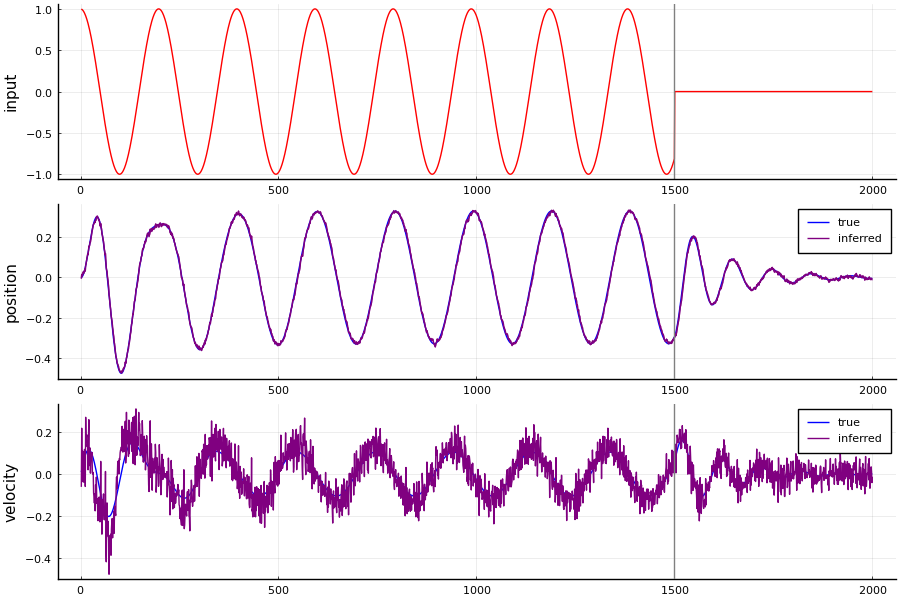

In [39]:
# Inputs
p201 = plot(2:T, input[2:T], color="red", ylabel="input", label="")
vline!([stop], color="gray", label="")

# Position
p202 = plot(2:T, states[2:T,1], color="blue", ylabel="position", label="true")
# scatter!(2:T, output[2:T], markersize=2, alpha=0.5, color="black", label="outputs")
plot!(2:T, est_states[1][2:T,1], color="purple", label="inferred")
plot!(2:T, est_states[1][2:T,1], ribbon=[sqrt.(est_states[2][2:T,1]), sqrt.(est_states[2][2:T,1])], alpha=0.5, color="purple", label="")
vline!([stop], color="gray", label="")

# Velocity
p203 = plot(2:T, states[2:T,2], color="blue", ylabel="velocity", label="true")
plot!(2:T, est_states[1][2:T,2], color="purple", label="inferred")
# plot!(2:T, est_states[1][2:T,2], ribbon=[sqrt.(est_states[2][2:T,2]), sqrt.(est_states[2][2:T,2])], alpha=0.5, color="purple", label="")
vline!([stop], color="gray", label="")

plot(p201, p202, p203, layout=(3,1), size=(900,600))

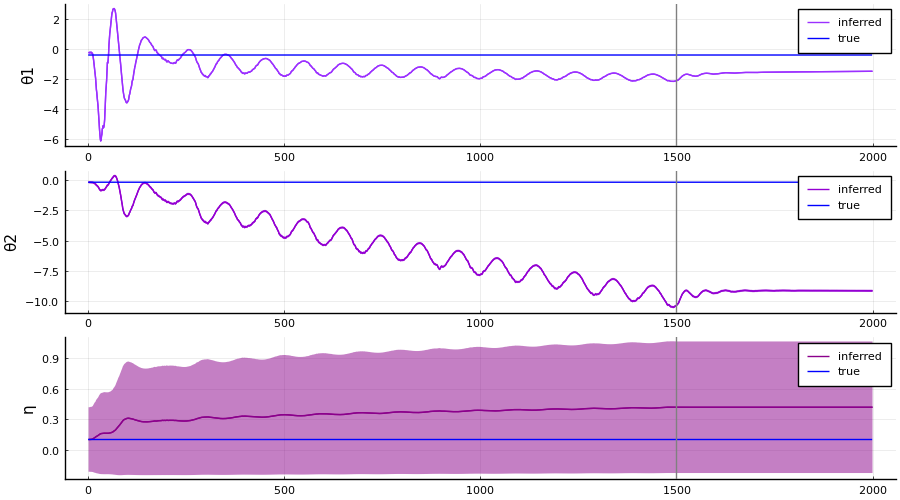

In [40]:
# First state coefficient
p201 = plot(2:T, est_coeffs[1][2:T,1], color="purple1", ylabel="θ1", label="inferred")
plot!(2:T, est_coeffs[1][2:T,1], ribbon=[sqrt.(est_coeffs[2][2:T,1]), sqrt.(est_coeffs[2][2:T,1])], color="purple1", label="")
plot!(θ_true[1]*ones(T-1,), label="true", color="blue")
vline!([stop], color="gray", label="")

# Second state coefficient
p202 = plot(2:T, est_coeffs[1][2:T,2], color="darkviolet", ylabel="θ2", label="inferred")
plot!(2:T, est_coeffs[1][2:T,2], ribbon=[sqrt.(est_coeffs[2][2:T,2]), sqrt.(est_coeffs[2][2:T,2])], color="darkviolet", label="")
plot!(θ_true[2]*ones(T-1,), label="true", color="blue")
vline!([stop], color="gray", label="")

# Control coefficient
p203 = plot(2:T, est_coeffs[1][2:T,3], color="darkmagenta", ylabel="η", label="inferred")
plot!(2:T, est_coeffs[1][2:T,3], ribbon=[sqrt.(est_coeffs[2][2:T,3]), sqrt.(est_coeffs[2][2:T,3])], color="darkmagenta", label="")
plot!(η_true*ones(T-1,), label="true", color="blue")
vline!([stop], color="gray", label="")

plot(p201,p202,p203, layout=(3,1), size=(900,500))

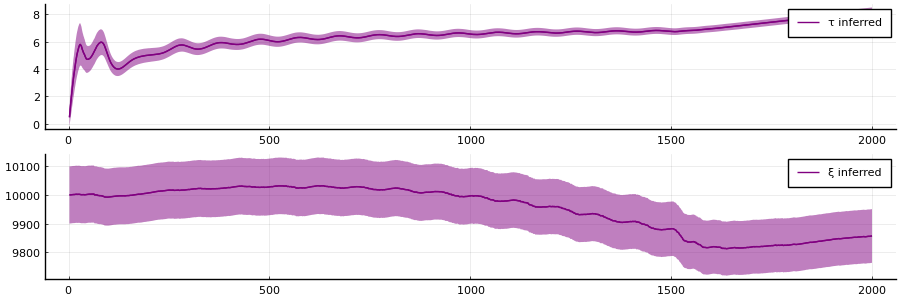

In [41]:
# Process noise precision
p401 = plot(2:T, est_noises[1][2:T,1], color="purple", label="τ inferred")
plot!(2:T, est_noises[1][2:T,1], ribbon=[sqrt.(est_noises[2][2:T,1]), sqrt.(est_noises[2][2:T,1])], color="purple", label="")
# plot!(ξ_true[1]*ones(T-2,), label="ξ true", color="green")

# Measurement noise precision
p402 = plot(2:T, est_noises[1][2:T,2], color="purple", label="ξ inferred")
plot!(2:T, est_noises[1][2:T,2], ribbon=[sqrt.(est_noises[2][2:T,2]), sqrt.(est_noises[2][2:T,2])], color="purple", label="")
# plot!(ξ_true[1]*ones(T-2,), label="ξ true", color="green")

plot(p401, p402, layout=(2,1), size=(900,300))

#### Validate identified system

We validate the identified system by computing simulation error on the validation set.

In [42]:
# Time horizon
T_val = 1000

# Input signal
input_val = cos.(Δt .*(1:T_val)./π);

In [43]:
# Preallocate arrays
states_val = zeros(T_val,2)
output_val = zeros(T_val,)

# Preallocate prediction arrays
preds = (zeros(T_val,2), zeros(T_val,2,2))

# Initial states
states_val[1,1] = 0.0
states_val[1,2] = 0.0

# Initial predictions
preds[1][1,:] = states_val[1,:]
preds[2][1,:,:] = I(2)

# Convenience variables
EA = (S + s*mn(marginals[:θ])')
EB = s*mn(marginals[:η])

@showprogress for k = 2:T_val
    
    # Simulate forward
    output_val[k], states_val[k,:] = sim_sys(input_val[k], states_val[k-1,:], subs_params)
    
    # Posterior predictive
    preds[1][k,:] = EA*preds[1][k-1,:] + EB*input_val[k]
    preds[2][k,:,:] = EA*preds[2][k-1,:,:]*EA' + inv(mn(marginals[:τ]))*noisecov(Δt, dims=2)

end

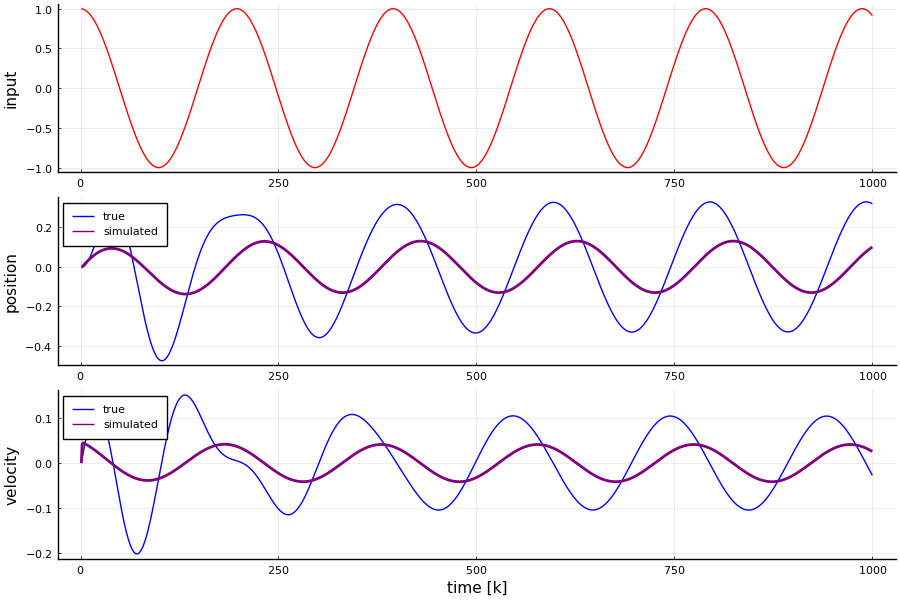

In [44]:
# zoom = 3:min(300,T_val)
zoom = 1:T_val

# Input
p301 = plot(zoom, input_val[zoom], ylabel="input", label="", color="red")

# Simulated position
p302 = plot(zoom, states_val[zoom,1], ylabel="position", label="true", color="blue", size=(900,300), legend=:topleft)
plot!(zoom, preds[1][zoom,1], label="simulated", linewidth=2, color="purple")
# plot!(zoom, preds[1][zoom,1], ribbon=[sqrt.(preds[2][zoom,1,1]), sqrt.(preds[2][zoom,1,1])], label="", color="purple")

# Simulated velocity
p303 = plot(zoom, states_val[zoom,2], ylabel="velocity", label="true", xlabel="time [k]", color="blue", size=(900,300), legend=:topleft)
plot!(zoom, preds[1][zoom,2], label="simulated", linewidth=2, color="purple")
# plot!(zoom, preds[1][zoom,2], ribbon=[sqrt.(preds[2][zoom,2,2]), sqrt.(preds[2][zoom,2,2])], label="", color="purple")

p300 = plot(p301,p302,p303, layout=(3,1), size=(900,600))

In [45]:
savefig(p300, "figures/simulations.png")

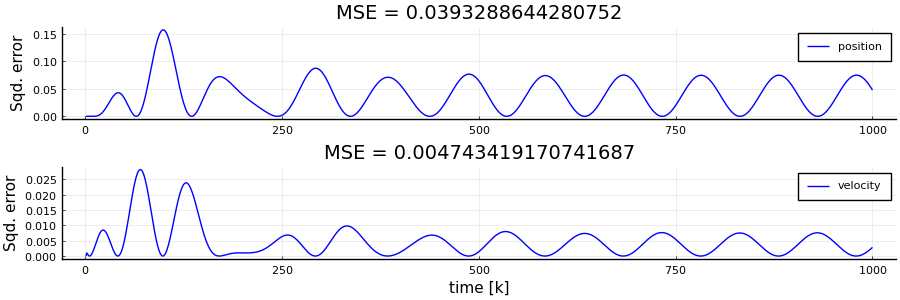

In [46]:
# Compute prediction error
sq_pred_error = (preds[1] .- states_val).^2

# Simulation error
MSE_sim = mean(sq_pred_error, dims=1)

# Scatter error over time
p501 = plot(1:T_val, sq_pred_error[:,1], color="blue", ylabel="Sqd. error", label="position")
title!("MSE = "*string(MSE_sim[1]))
p502 = plot(1:T_val, sq_pred_error[:,2], color="blue", xlabel="time [k]", ylabel="Sqd. error", label="velocity")
title!("MSE = "*string(MSE_sim[2]))

p500 = plot(p501, p502, layout=(2,1), size=(900,300))

In [47]:
savefig(p500, "figures/known-input_sim-errors.png")

### Experiment 2: Online system identification with agent-regulated inputs

In [148]:
function EFE(action, state_k, goal_state, params; Δt = 1., time_horizon=1)
    "Expected Free Energy"
    
    # Unpack goal state
    μ_star = goal_state[1]
    Σ_star = goal_state[2]

    # Unpack model parameters
    θ, η, τ, ξ = params

    # Process noise
    Σ_z = inv(τ)*[Δt^3/3 Δt^2/2; Δt^2/2 Δt]

    # Utility matrices
    S = [1. Δt; 0. 1.]
    s = [0., Δt]
    
    # Model matrices
    A = S + s*θ'
    B = s*η
    C = [1., 0.]'

    # Unpack prior state     
    μ_tmin1 = mn(state_k)
    Σ_tmin1 = cv(state_k)
    
    cumEFE = 0
    for t in 1:time_horizon
        
        # State transition
        μ_t = A*μ_tmin1 + B*action[t]
        Σ_t = A*Σ_tmin1*A' + Σ_z

        # Predicted observation 
        y_t = C*μ_t

        # Block covariance matrix of joint
        Σ_11 = Σ_t
        Σ_21 = C*Σ_t
        Σ_12 = Σ_t*C'
        Σ_22 = C*Σ_t*C' .+ inv(ξ)

        # Calculate conditional entropy
#         Σ_cond = Σ_22 - Σ_21*inv(Σ_11)*Σ_12
        Σ_cond = inv(ξ)[1]
        ambiguity = 0.5(log2π + log(Σ_cond) - 1)
        
        # Risk as KL between marginal and goal prior
        risk = 0.5*(log(det(Σ_star)/det(Σ_22)) + 1 + (y_t - μ_star)'*inv(Σ_star)*(y_t - μ_star) + tr(inv(Σ_star)*Σ_22))
#         risk = KLDivergence(y_t[1], Σ_22[1], goal_state[1], goal_state[2])
        
        # Add to cumulative EFE
        cumEFE += risk + ambiguity
        
        # Update previous state
        μ_tmin1 = μ_t
        Σ_tmin1 = Σ_t
        
    end
    return cumEFE
end;

In [149]:
# goal_state = (.2, 1e-2)
# model_params = (θ_true, η_true, Inf, ξ_true)
# G(u) = EFE([u, 1], marginals[:z], goal_state, model_params, Δt=Δt, time_horizon=2)

# policy = collect(-1000:1000)
# plot(policy, G.(policy))

#### Execute all planned actions

In [167]:
# Trial time
T = 2000

# Planning time horizon
TT = 10

# Generate planning points
plan_t = 2:TT:T;

In [168]:
# Goal state (mean and var)
goal_state = (-.5, 1e-4)

# Number of variational updates
num_iterations = 10

# Preallocation
input = zeros(T,)
states = zeros(T,2)
output = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=I(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=I(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[-.1, -.1], w=1e0*I(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=0.1, w=1e0)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1e0, b=1e-1)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e6, b=1e2)

# Track estimated states
est_states = (zeros(T,2), zeros(T,2))
est_coeffs = (zeros(T,3), zeros(T,3))
est_noises = (zeros(T,2), zeros(T,2))

@showprogress for k = 2:T
    
    "Plan actions"

    if k in plan_t
    
        # Pack parameters estimated by model
        model_params = (mn(marginals[:θ]), mn(marginals[:η]), mn(marginals[:τ]), mn(marginals[:ξ]))
#         model_params = (mn(marginals[:θ]), mn(marginals[:η]), Inf, mn(marginals[:ξ]))

        # Objective function
        G(u_k) = EFE(u_k, marginals[:z], goal_state, model_params, Δt=Δt, time_horizon=TT)

        # Miminimize EFE
        results = optimize(G, -3, 3, 2*rand(TT,).-1, Fminbox(LBFGS()), Optim.Options(iterations=1000); autodiff=:forward)
#         results = optimize(G, randn(TT,), LBFGS(), Optim.Options(iterations=100); autodiff=:forward)
    
        # Add policy to input signal 
        if k+TT-1 > T
            input[k:T] = Optim.minimizer(results)[1:T-k+1]
        else
            input[k:k+TT-1] = Optim.minimizer(results)
        end      
    end
    
    "Execute control"
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], subs_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => output[k],
                       :u => input[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
        stepη!(constraints, marginals)
        stepθ!(constraints, marginals)
        
        # Update states
        stepz!(constraints, marginals)
        stepx!(constraints, marginals)
        
        # Update noise precisions
        stepτ!(constraints, marginals)
        stepξ!(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z])
    est_states[2][k,:] = diag(cv(marginals[:z]))
    est_coeffs[1][k,1:2] = mn(marginals[:θ])
    est_coeffs[1][k,3] = mn(marginals[:η])
    est_coeffs[2][k,1:2] = diag(cv(marginals[:θ]))
    est_coeffs[2][k,3] = mn(marginals[:η])
    est_noises[1][k,1] = mn(marginals[:τ])
    est_noises[1][k,2] = mn(marginals[:ξ])
    est_noises[2][k,1] = var(marginals[:τ])
    est_noises[2][k,2] = var(marginals[:ξ])
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


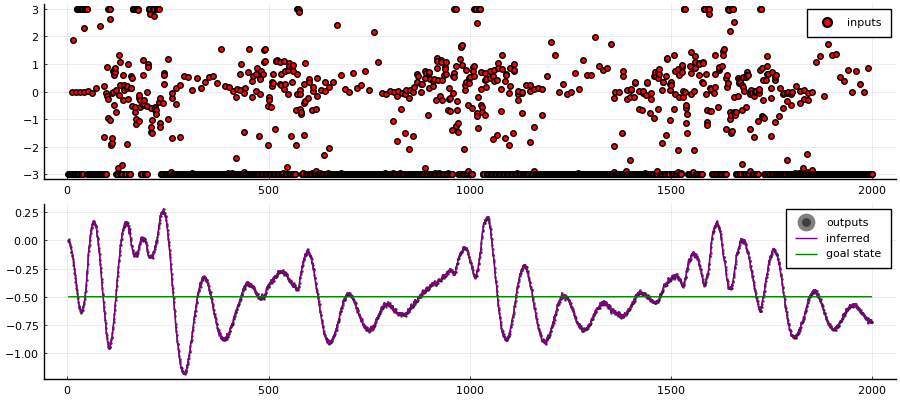

In [169]:
p601 = scatter(2:T, input[2:T], color="red", label="inputs")
p602 = scatter(2:T, output[2:T], color="black", markersize=1, alpha=0.5, label="outputs")
plot!(2:T, est_states[1][2:T,1], color="purple", label="inferred")
plot!(2:T, est_states[1][2:T,1], ribbon=[est_states[2][2:T,1], est_states[2][2:T,1]], color="purple", label="")
plot!(2:T, goal_state[1]*ones(T-1,), color="green", label="goal state")
p600 = plot(p601, p602, layout=(2,1), size=(900,400))

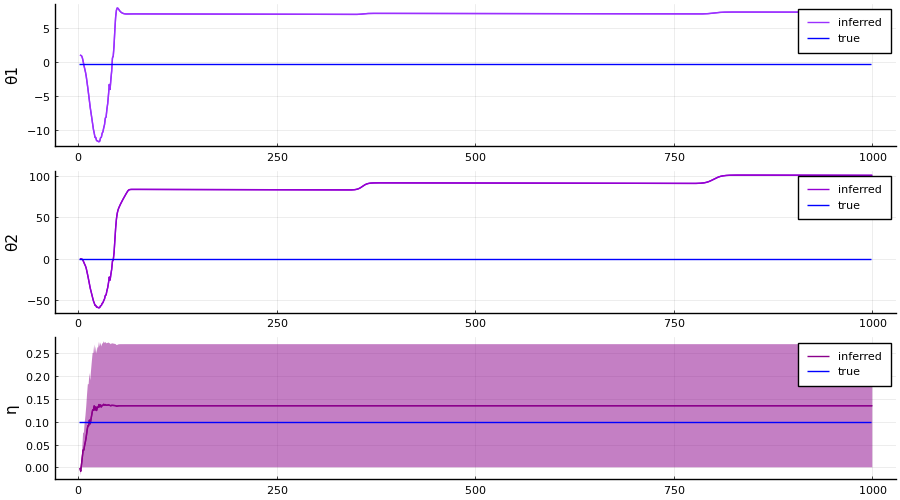

In [166]:
# First state coefficient
p211 = plot(2:T, est_coeffs[1][2:T,1], color="purple1", ylabel="θ1", label="inferred")
plot!(2:T, est_coeffs[1][2:T,1], ribbon=[est_coeffs[2][2:T,1], est_coeffs[2][2:T,1]], color="purple1", label="")
plot!(θ_true[1]*ones(T-1,), label="true", color="blue")

# Second state coefficient
p212 = plot(2:T, est_coeffs[1][2:T,2], color="darkviolet", ylabel="θ2", label="inferred")
plot!(2:T, est_coeffs[1][2:T,2], ribbon=[est_coeffs[2][2:T,2], est_coeffs[2][2:T,2]], color="darkviolet", label="")
plot!(θ_true[2]*ones(T-1,), label="true", color="blue")

# Control coefficient
p213 = plot(2:T, est_coeffs[1][2:T,3], color="darkmagenta", ylabel="η", label="inferred")
plot!(2:T, est_coeffs[1][2:T,3], ribbon=[est_coeffs[2][2:T,3], est_coeffs[2][2:T,3]], color="darkmagenta", label="")
plot!(η_true*ones(T-1,), label="true", color="blue")

p210 = plot(p211,p212,p213, layout=(3,1), size=(900,500))

#### Execute first planned action only

In [133]:
# Trial time
T = 500

# Planning time horizon
TT = 6
    
# Goal state (mean and std dev)
goal_state = (-.5, 1e-6)

# Number of variational updates
num_iterations = 5

# Preallocation
input = zeros(T,)
states = zeros(T,2)
output = zeros(T,)

# Initialize constraints
constraints = Dict()

# Initialize marginals in factor graph
marginals = Dict()
marginals[:x] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=.1*I(2))
marginals[:z] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=.1*I(2))
marginals[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=zeros(2,), w=1e-2*I(2))
marginals[:η] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=0.0, w=1e-2)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=1e-2, b=1e-1)
marginals[:ξ] = ProbabilityDistribution(Univariate, Gamma, a=1e4, b=1e0)

# Track estimated states
est_states = (zeros(T,2), zeros(T,2))
est_coeffs = (zeros(T,3), zeros(T,3))
est_noises = (zeros(T,2), zeros(T,2))

@showprogress for k = 2:T
    
    "Find control"

    # Pack parameters estimated by model
    model_params = (mn(marginals[:θ]), mn(marginals[:η]), mn(marginals[:τ]), mn(marginals[:ξ]))

    # Objective function
    G(u_k) = EFE(u_k, marginals[:z], goal_state, model_params, Δt=Δt, time_horizon=TT)

    # Miminimize EFE
    results = optimize(G, -10, 10, 2*rand(TT,) .-1, Fminbox(LBFGS()), Optim.Options(iterations=100); autodiff=:forward)
#     results = optimize(G, randn(TT,), LBFGS(), Optim.Options(iterations=100); autodiff=:forward)

    # Execute first planned action only
    input[k] = Optim.minimizer(results)[1]
    
    "Execute control"
    
    # Execute input and observe output
    output[k], states[k,:] = sim_sys(input[k], states[k-1,:], subs_params)
    
    "Update model params"
    
    # Update constraints
    constraints = Dict(:y => output[k],
                       :u => input[k],
                       :m_x => mn(marginals[:z]),
                       :w_x => pc(marginals[:z]),
                       :m_θ => mn(marginals[:θ]),
                       :w_θ => pc(marginals[:θ]),
                       :m_η => mn(marginals[:η]),
                       :w_η => pc(marginals[:η]),
                       :a_τ => marginals[:τ].params[:a],
                       :b_τ => marginals[:τ].params[:b],
                       :a_ξ => marginals[:ξ].params[:a],
                       :b_ξ => marginals[:ξ].params[:b])

    # Iterate recognition factor updates
    for ii = 1:num_iterations

        # Update parameters
        stepθ!(constraints, marginals)
        stepη!(constraints, marginals)
        
        # Update states
        stepz!(constraints, marginals)
        stepx!(constraints, marginals)
        
        # Update noise precisions
        stepτ!(constraints, marginals)
        stepξ!(constraints, marginals)
        
    end    
    
    # Store state estimates
    est_states[1][k,:] = mn(marginals[:z])
    est_states[2][k,:] = diag(cv(marginals[:z]))
    est_coeffs[1][k,1:2] = mn(marginals[:θ])
    est_coeffs[1][k,3] = mn(marginals[:η])
    est_coeffs[2][k,1:2] = diag(cv(marginals[:θ]))
    est_coeffs[2][k,3] = mn(marginals[:η])
    est_noises[1][k,1] = mn(marginals[:τ])
    est_noises[1][k,2] = mn(marginals[:ξ])
    est_noises[2][k,1] = var(marginals[:τ])
    est_noises[2][k,2] = var(marginals[:ξ])
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


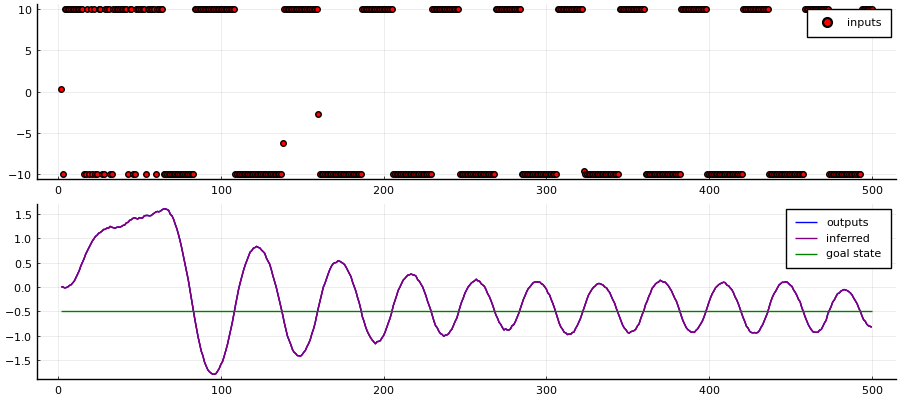

In [135]:
p1 = scatter(2:T, input[2:T], color="red", label="inputs")
p2 = plot(2:T, output[2:T], color="blue", label="outputs")
plot!(2:T, est_states[1][2:T,1], color="purple", label="inferred")
plot!(2:T, est_states[1][2:T,1], ribbon=[est_states[2][2:T,1], est_states[2][2:T,1]], color="purple", label="")
plot!(2:T, goal_state[1]*ones(T-1,), color="green", label="goal state")
plot(p1, p2, layout=(2,1), size=(900,400))

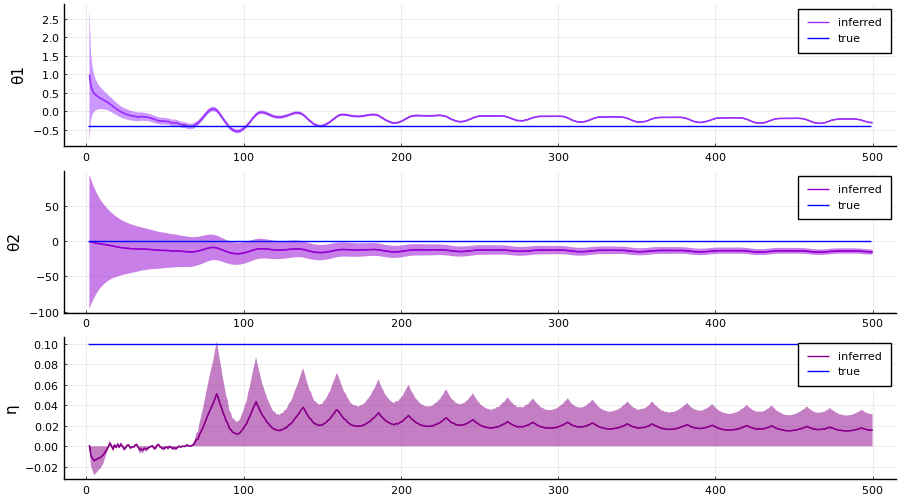

In [136]:
# First state coefficient
p211 = plot(2:T, est_coeffs[1][2:T,1], color="purple1", ylabel="θ1", label="inferred")
plot!(2:T, est_coeffs[1][2:T,1], ribbon=[est_coeffs[2][2:T,1], est_coeffs[2][2:T,1]], color="purple1", label="")
plot!(θ_true[1]*ones(T-1,), label="true", color="blue")

# Second state coefficient
p212 = plot(2:T, est_coeffs[1][2:T,2], color="darkviolet", ylabel="θ2", label="inferred")
plot!(2:T, est_coeffs[1][2:T,2], ribbon=[est_coeffs[2][2:T,2], est_coeffs[2][2:T,2]], color="darkviolet", label="")
plot!(θ_true[2]*ones(T-1,), label="true", color="blue")

# Control coefficient
p213 = plot(2:T, est_coeffs[1][2:T,3], color="darkmagenta", ylabel="η", label="inferred")
plot!(2:T, est_coeffs[1][2:T,3], ribbon=[est_coeffs[2][2:T,3], est_coeffs[2][2:T,3]], color="darkmagenta", label="")
plot!(η_true*ones(T-1,), label="true", color="blue")

p210 = plot(p211,p212,p213, layout=(3,1), size=(900,500))

#### Validation

In [64]:
# Time horizon
T_val = 1000

# Input signal
inputs_val = cos.(Δt .*range(1, stop=T_val) /π);

In [65]:
# Preallocate arrays
states_val = zeros(T_val,2)
output_val = zeros(T_val,)

# Convenience variables
EA = (S + s*mn(marginals[:θ])')
EB = s*mn(marginals[:η])

# Preallocate prediction arrays
preds = (zeros(T_val,2), zeros(T_val,2,2))

@showprogress for k = 2:T_val
    
    # Simulate forward
    output_val[k], states_val[k,:] = sim_sys(input_val[k], states_val[k-1,:], subs_params)
    
    # Posterior predictive
    preds[1][k,:] = EA*preds[1][k-1,:] + EB*input_val[k]
    preds[2][k,:,:] = EA'*preds[2][k-1,:,:]*EA + inv(mn(marginals[:τ]))*noisecov(Δt, dims=2)

end

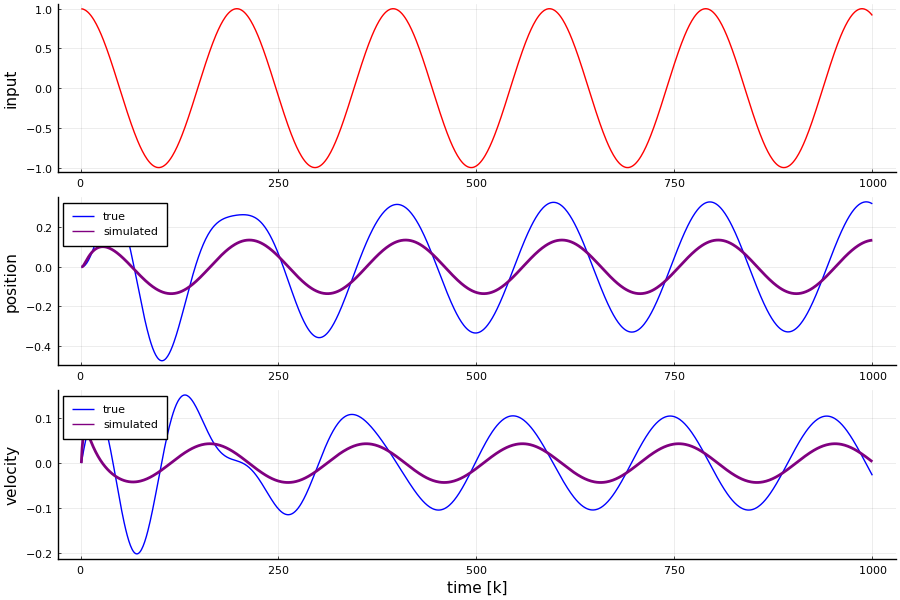

In [66]:
# zoom = 3:min(300,T_val)
zoom = 1:T_val

# Input
p301 = plot(zoom, input_val[zoom], ylabel="input", label="", color="red")

# Simulated position
p302 = plot(zoom, states_val[zoom,1], ylabel="position", label="true", color="blue", size=(900,300), legend=:topleft)
plot!(zoom, preds[1][zoom,1], label="simulated", linewidth=2, color="purple")
# plot!(zoom, preds[1][zoom,1], ribbon=[sqrt.(preds[2][zoom,1,1]), sqrt.(preds[2][zoom,1,1])], label="", color="purple")

# Simulated velocity
p303 = plot(zoom, states_val[zoom,2], ylabel="velocity", label="true", xlabel="time [k]", color="blue", size=(900,300), legend=:topleft)
plot!(zoom, preds[1][zoom,2], label="simulated", linewidth=2, color="purple")
# plot!(zoom, preds[1][zoom,2], ribbon=[sqrt.(preds[2][zoom,2,2]), sqrt.(preds[2][zoom,2,2])], label="", color="purple")

p300 = plot(p301,p302,p303, layout=(3,1), size=(900,600))

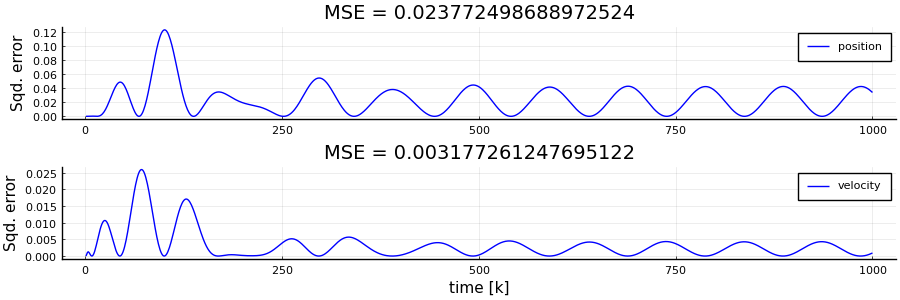

In [68]:
# Compute prediction error
sq_pred_error = (preds[1] .- states_val).^2

# Simulation error
MSE_sim = mean(sq_pred_error, dims=1)

# Scatter error over time
p601 = plot(1:T_val, sq_pred_error[:,1], color="blue", ylabel="Sqd. error", label="position")
title!("MSE = "*string(MSE_sim[1]))
p602 = plot(1:T_val, sq_pred_error[:,2], color="blue", xlabel="time [k]", ylabel="Sqd. error", label="velocity")
title!("MSE = "*string(MSE_sim[2]))

p600 = plot(p601, p602, layout=(2,1), size=(900,300))

In [ ]:
savefig(p600, "figures/agent-input_sim-errors.png")